# training_utils

> Utility functions for training. These include getters for a loss functions, an optimizers and a function to evaluate metrics.

In [ ]:
#| default_exp training_utils

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.utils import *

In [ ]:
from birdclef.dataset import get_dataloader
from birdclef.network import get_model

In [ ]:
#| export
from operator import gt, lt
from IPython.display import Audio
from IPython.core.display import display

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import torch

from birdclef.utils import plot_spectrogram, mel_to_wave

C:\Users\giach\AppData\Local\Temp\ipykernel_17988\3461455213.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [ ]:
#| export
losses_dict = {
    'ce': torch.nn.CrossEntropyLoss
}

def get_loss_func(loss:str # Key into the losses dictionary
                    ):
    "Getter method to retrieve a loss function"

    assert loss in losses_dict.keys(), f'{loss} is not an existing loss function, choose one from {losses_dict.keys()}.'
    
    return losses_dict[loss]()

In [ ]:
#|echo: false
print("The existing keys are:\n" + "\n".join([k for k in losses_dict.keys()]))

test_eq(len(losses_dict.keys()), 1)

The existing keys are:
bce


In [ ]:
#| export
optimizers_dict = {
    'adamw': torch.optim.AdamW
}

def get_optimizer(optim:str, # Key into the optimizer dictionary
                  model:torch.nn.Module, # The trained model
                  kwargs:dict # Optimizer parameters
                    ):
    "Getter method to retrieve an optimizer"

    assert optim in optimizers_dict.keys(), f'{optim} is not an existing optimizer, choose one from {optimizers_dict.keys()}.'
    
    return optimizers_dict[optim](model.parameters(), **kwargs)

In [ ]:
#|echo: false
print("The existing keys are:\n" + "\n".join([k for k in optimizers_dict.keys()]))

test_eq(len(optimizers_dict.keys()), 1)

The existing keys are:
adamw


In [ ]:
#| export
def compute_metrics(name:str,               # Name of the training stage (train, val, test)
                    outputs:torch.Tensor,   # The output of the model       
                    labels:torch.Tensor,    # The ground truth
                    loss:float,             # The loss of the model
                    example_ct:int,         # Number of examples processed by the model
                    step_ct:int,            # Number of backpropagation steps the model has done
                    epoch:float             # The training epoch
                    )->dict:                # Dictionary of the metrics
        "Compute new metrics from outputs and labels and format existing ones."

        # Transforming logits in probabilities
        outputs = torch.nn.functional.softmax(outputs, dim=1)

        # Transforming outputs into one hot encoding
        outputs = torch.zeros_like(outputs).scatter_(1, torch.argmax(outputs, dim=1).unsqueeze(-1), 1.)
        labels, outputs = labels.cpu(), outputs.cpu()

        acc = accuracy_score(labels, outputs)
        prec, recall, f1_weighted, _ = precision_recall_fscore_support(labels, outputs, average='weighted', zero_division=0.0)
    
        return {f'{name}/loss': loss,
            f'{name}/example_ct': example_ct,
            f'{name}/step_ct': step_ct,
            f'{name}/epoch': epoch,
            f'{name}/accuracy': acc,
            f'{name}/precision': prec,
            f'{name}/recall': recall,
            f'{name}/f1': f1_weighted,
            }

In [ ]:
#| export
metrics_dict = {
    'loss': lt,
    'step': gt,
    'accuracy': gt,
    'precision': gt,
    'recall': gt,
    'f1': gt,
}

A metrics dictionary is also provided having metrics names as key and comparison functions as values.

In [ ]:
#|echo: false
print("The existing keys are:\n" + "\n".join([k for k in metrics_dict.keys()]))

The existing keys are:
loss
step
accuracy
precision
recall
f1


The function in the metrics dictionary specify which operator must be used to evaluate the better metric. For instance we consider a loss to be better when is smaller.

In [ ]:
test_eq(metrics_dict['loss'](0.1, 0.2), True)
test_eq(metrics_dict['loss'](0.05, 0.001), False)
test_eq(metrics_dict['step'](500, 420), True)

## Callback functions

In [ ]:
#| export
def show_one_example(inputs:torch.Tensor, # The inputs to the model
                     labels:torch.Tensor, # The ground truth
                     outputs:torch.Tensor): # The model prediction
    "A function that shows one input to the model together with its label and prediction"
    inputs, labels, outputs = inputs.cpu(), labels.cpu(), outputs.cpu()
    print(outputs.shape)
    outputs = torch.nn.functional.softmax(outputs, dim=1)

    print(f'Ground truth: {labels[0]}\nOutputs: {outputs[0]}')
    plot_spectrogram(inputs[0][0], db=True)
    waveform = mel_to_wave(inputs[0][0])
    display(Audio(waveform.numpy(), rate=32000))
    

157
torch.Size([1, 3])
Ground truth: tensor([1., 0., 0.])
Outputs: tensor([1., 1., 1.], grad_fn=<SelectBackward0>)


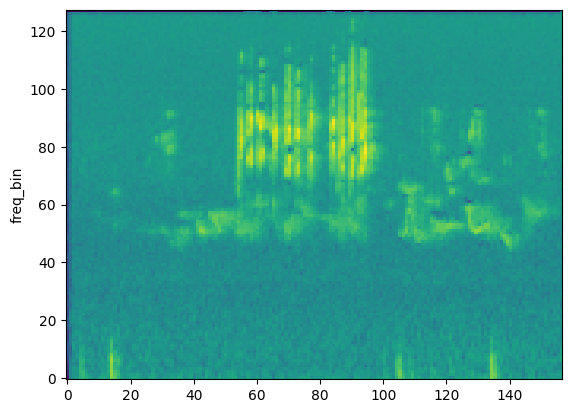

In [ ]:
dl = get_dataloader('train_simple')
model = get_model('simple_efficient_net_v2_s')
inputs, labels = next(iter(dl))
outputs = model(inputs)
show_one_example(inputs, labels, outputs)

In [ ]:
#| export
callback_dict = {
    '': None,
    'show': show_one_example
}

def get_callback_func(callback:str # Key into the callback dictionary
                    ):
    "Getter method to retrieve a callback function"

    assert callback in callback_dict.keys(), f'{callback} is not an existing callback function, choose one from {losses_dict.keys()}.'
    
    return callback_dict[callback]

In [ ]:
#|echo: false
print("The existing keys are:\n" + "\n".join([k for k in callback_dict.keys()]))

The existing keys are:

show


The empty key means no callback will be present

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()